In [636]:
# imports 
import pandas as pd 
import pickle
import glob
import re 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

In [650]:
# read in the set of phrogs that we want to use for threshold selection
# Get the phrogs that pass the length and plddt filters 
with open('/home/grig0076/GitHubs/phlegm/files/phrogs_pass_plddt_length_threshold_alphafold_trained.txt', 'r') as file:
    phrogs_pass_alphafold_seen =  [line.strip() for line in file]

# read in the ones that haven't been seen by alphafold
with open('/home/grig0076/GitHubs/phlegm/files/phrogs_pass_plddt_length_threshold_validation_alphafold_unseen.txt', 'r') as file:
    phrogs_pass_alphafold_unseen =  [line.strip() for line in file]
    
# read in the manually curated monomers 
manual_monomers = pd.read_csv('/home/grig0076/GitHubs/phlegm/files/manual_monomer_curation_20250723.csv')
manual_monomers_phrogs = manual_monomers.dropna()['PHROG'].to_list() 

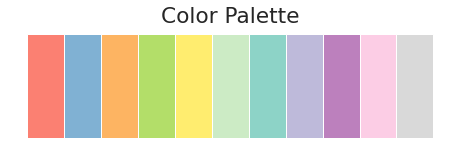

In [651]:
colors = ['#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#ffed6f', '#ccebc5', '#8dd3c7',   '#bebada', '#bc80bd','#fccde5', 
          '#d9d9d9']


# Plot the colors using a bar plot
plt.figure(figsize=(8, 2))
plt.bar(range(len(colors)), [1]*len(colors), color=colors, width=1)

# Customize the appearance
plt.axis('off')  # Turn off the axis
plt.title('Color Palette')

# Display the plot
plt.show()

In [662]:
# read in the oligomeric state of these as deposited in the pdb 
alphafold_known_state = pickle.load(open('/home/grig0076/GitHubs/phlegm/files/phrogs_pass_plddt_length_threshold_oligomeric_state.pkl', 'rb'))

# large oligomers - I have a table in the supp info that contains this information 
large_oligomeric_manual = {'phrog_45': 'Homo 6-mer', 
'phrog_659': 'Homo 18-mer', 
'phrog_55': 'Homo 6-mer', 
'phrog_33753': 'Homo 35-mer',
'phrog_36144': '8-mer', 
'phrog_38392': '24-mer', 
'phrog_432': '2-mer', 
'phrog_267': 'Homo 6-mer', # also pentameric - but these are grouped together for classification
'phrog_247': 'Homo 6-mer', # also pentameric - but these are grouped together for classification 
'phrog_371': 'Homo 6-mer',  # also pentameric - but these are grouped together for classification
'phrog_16897': 'Homo 20-mer'}

In [663]:
# apply criteria to filter this dictionary 
keys = list(alphafold_known_state.keys())

phrogs_pass_alphafold_seen_state = dict()
labelled_monomers = [] # flag the monomers as these require manual curation 

for k in keys: 
    
    # see if phrog has been curated as a Monomer manually
    # nothing is happening here at the moment - not currently incorporating the manual check 

    if list(alphafold_known_state.get(k).keys()) == ['Monomer']: # this here is if it is only ever listed as a monomer 
        
        # only if in the manually curated set 
        if k in manual_monomers_phrogs:
            phrogs_pass_alphafold_seen_state[k] = 'Monomer'
            labelled_monomers.append(k)
    
    # otherwise look at pdb hits 
    else: 
        states = alphafold_known_state.get(k)

        # correct any keys in states that mention more than one state
        double_keys = [s for s in list(states.keys()) if '\'' in s] 
        if len(double_keys) > 0: 

            for j in double_keys: 
                split = re.split(', ', j) 
                for s in split: 
                    if s in list(states.keys()):
                        states[s.replace('\'', '')] += 1
                    else: 
                        states[s.replace('\'', '')] = 1

                del states[j]

    
        # Delete monomers from the states dictionary - if there is a high state this is more likely 
        if 'Monomer' in list(states.keys()):
            del states['Monomer']
            
            
        # TODO return here to see if there are any missing from the manual curation 
        
        # apply criteria that there shouldn't be more than 3 possible states 
        if len(states) > 3: 
            phrogs_pass_alphafold_seen_state[k] = 'ambiguous'
        
        # check that the 'winning' state represents at least 70% of the hits 
        else: 
            
            if len(states) > 0: 
                
                if k in list(large_oligomeric_manual.keys()): 
                    phrogs_pass_alphafold_seen_state[k] = large_oligomeric_manual.get(k)
                
                else:
                    # generate a dataframe with number of hits to each state
                    hits_df = pd.DataFrame.from_dict(states, orient='index').sort_values(0, ascending=False)

                    # compute the 'dominance' of this top state 
                    dominance = hits_df.iloc[0]/hits_df[0].sum()

                    if dominance[0] >= 0.65: 
                        phrogs_pass_alphafold_seen_state[k] = hits_df.index[0]
                    else: 
                        phrogs_pass_alphafold_seen_state[k] = 'ambiguous'
     

In [664]:
# read in the metrics generated for the phrogs that pass the tests 
part_1 =  glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_001.phlegm/metrics_pickle/*.pkl')
part_2 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_002.phlegm/metrics_pickle/*.pkl')
part_3 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_003.phlegm/metrics_pickle/*.pkl')
part_4 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_004.phlegm/metrics_pickle/*.pkl')
part_5 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_005.phlegm/metrics_pickle/*.pkl')
part_6 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_006.phlegm/metrics_pickle/*.pkl') 
part_7 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_007.phlegm/metrics_pickle/*.pkl')
part_8 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_008.phlegm/metrics_pickle/*.pkl')
all_parts =  part_1 + part_2 + part_3 + part_4 + part_5 + part_6 + part_7 + part_8

In [665]:
all_phrogs_pickle_complete = [re.split('/', p)[-1][:-4] for p in all_parts]

# filter these to only inlucde the ones that pass the plddt cutoff 
all_phrogs_alphafold_seen_complete = list(set(all_phrogs_pickle_complete).intersection(set(phrogs_pass_alphafold_seen))) 

all_phrogs_pickle_complete_seen = np.array(all_phrogs_alphafold_seen_complete)[[True if a in phrogs_pass_alphafold_seen else False for a in all_phrogs_alphafold_seen_complete ]]
all_phrogs_pickle_complete_seen_path = np.array(all_parts)[[True if a in phrogs_pass_alphafold_seen else False for a in all_phrogs_pickle_complete]]

# make a dictionary that maps the phrog to its metrics path 
pickle_paths = dict(zip(all_phrogs_pickle_complete, all_parts))

## Classifier for assigning each PHROG to a different state

In [666]:
# group the nubmer of subunits into a bin 
state_bins_dict = {'Monomer': 'Monomer', 
  '2-mer': '2-mer', 
 'Homo 2-mer': '2-mer', 
'Homo 3-mer': '3-mer', 
'Homo 4-mer': '4-mer', 
'Homo 5-mer': '5-6-mer', 
'Homo 6-mer': '5-6-mer',
'Homo 7-mer': '7+-mer',
 '8-mer': '7+-mer',
'Homo 8-mer': '7+-mer',
'Homo 9-mer': '7+-mer',
'Homo 10-mer': '7+-mer',
 'Homo 12-mer': '7+-mer',
 'Homo 18-mer': '7+-mer',
  'Homo 20-mer': '7+-mer',
   '24-mer': '7+-mer',
}

In [658]:
# Map oligomeric states to their correct number of subunits
true_states = {
    'Monomer': 1,
    'Homo 2-mer': 2,
    '2-mer': 2, 
    'Homo 3-mer': 3,
    'Homo 4-mer': 4,
    'Homo 5-mer': 5,
    'Homo 6-mer': 6,
    'Homo 7-mer': 7,
    'Homo 8-mer': 8,
    '8-mer': 8, 
    'Homo 9-mer': 9,
    'Homo 10-mer': 10,
    'Homo 35-mer': 35, 
    'Homo 12-mer': 12, 
    'Homo 18-mer': 18, 
    'Homo 20-mer':20
}

# loop through the discovery phrogs to make a dataframe 
subunits_keys = ['2_subunits', '3_subunits', '4_subunits', '5_subunits', '6_subunits', '7_subunits', '8_subunits', '9_subunits', '10_subunits'] 
replicate_keys = ['rep_1', 'rep_2', 'rep_3'] # update to all 5 later
metrics_df = pd.DataFrame()

for p in  phrogs_pass_alphafold_seen:
    
    if p in list(pickle_paths.keys()):
        metrics = pickle.load(open(pickle_paths.get(p), 'rb'))

        for s in subunits_keys: 
            for r in replicate_keys: 
                m = metrics.get(s).get(r) 
                iptm = m.get('iptm')  
                ptm = m.get('ptm')
                mean_plddt = m.get('mean_plddt')
                mean_pdockq2 = np.mean(m.get('pdockq2'))
                mean_plddt_lst = np.mean(m.get('avgif_pae'))
                df = pd.DataFrame.from_dict({'iptm': iptm, 'ptm': ptm, 'mean_plddt':mean_plddt, 'mean_pdockq2': mean_pdockq2, 'mean_plddt_lst': mean_plddt_lst}, orient='index').T
                df['replicate'] = r
                df['subunits'] = str(int(re.split('_', s)[0]))
                df['state_bin'] = state_bins_dict.get(phrogs_pass_alphafold_seen_state.get(p))
                df['phrog'] = p

                metrics_df = pd.concat([metrics_df, df])

        # make the dataframe first and then go from there 

### make predictions my looping through the metrics 

In [659]:
phrogs_predict = list(set(metrics_df['phrog']))

# store this info in a dataframe like the others so that a prediction can be made 
iptm_predictions = pd.DataFrame() 

# dictionary to map predictions to their bin 
state_bins_dict = {1: 'Monomer', 
  2: '2-mer',  
3: '3-mer', 
4: '4-mer', 
5: '5-6-mer', 
6: '5-6-mer',
7: '7+-mer',
8: '7+-mer',
9: '7+-mer',
10: '7+-mer',
}

for p in phrogs_predict: 
    
    dd = metrics_df[metrics_df['phrog'] == p] 
    per_subunits_iptm = dd[['iptm', 'subunits', 'mean_plddt']].groupby('subunits').mean() 
    max_iptm = per_subunits_iptm.max()[0] 
    max_iptm_subunits = int(per_subunits_iptm.idxmax()[0])
    max_iptm_subunits_plddt = per_subunits_iptm.loc[per_subunits_iptm.idxmax()[0]]['mean_plddt'] # get the plddt of this prediction 
    
    # if this max is below a threshold then say it can't be predicted 
    if max_iptm<0.5 or max_iptm_subunits_plddt < 60: 
        max_iptm_subunits = 1
        
    results = pd.DataFrame.from_dict({'phrog': p, 'max_iptm': max_iptm, 'max_iptm_subunits': max_iptm_subunits, 'curated_state_bin': dd['state_bin'].iloc[0], 'prediction_state_bin': state_bins_dict.get(max_iptm_subunits) }, orient='index').T
    iptm_predictions = pd.concat([iptm_predictions, results])
    
    #sns.lineplot(data=metrics_df[metrics_df['phrog'] == p], x='subunits', y='iptm')
    #print(dd['state_bin'].iloc[0])
    #plt.show()
    
# Create column indicating whether prediction was correct
iptm_predictions['is_correct'] = iptm_predictions['curated_state_bin'] == iptm_predictions['prediction_state_bin']

# Optional: short label
iptm_predictions['correct_label'] = iptm_predictions['is_correct'].map({True: "Correct", False: "Incorrect"})

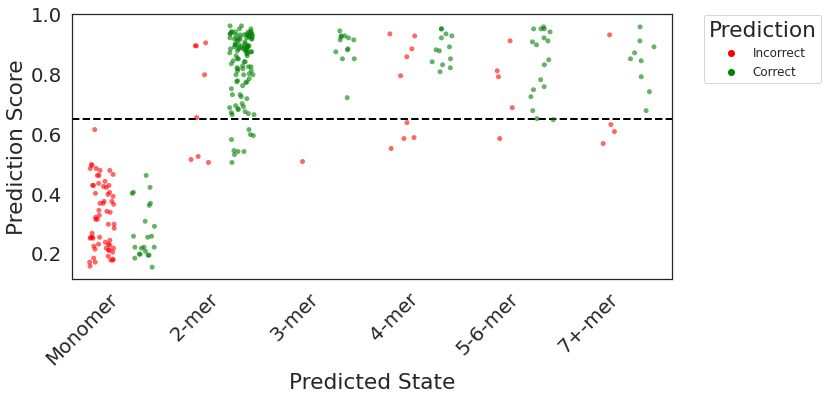

In [660]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='white', font_scale=1.8)
plt.figure(figsize=(12, 6))

desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer'] 

# Create the stripplot
sns.stripplot(data=iptm_predictions.dropna(), x='prediction_state_bin', y='max_iptm', hue='correct_label', dodge=True, jitter=0.25, alpha=0.6,
              palette={'Correct': 'green', 'Incorrect': 'red'},
              order=desired_order)

# Add dashed line at y=0.7
plt.axhline(y=0.65, color='black', linestyle='--', linewidth=2)

# Add legend
plt.xlabel("Predicted State")
plt.ylabel("Prediction Score")
plt.legend(
    title="Prediction",
    loc='upper left',  # Position inside the plot area (upper left corner)
    bbox_to_anchor=(1.05, 1),  # Move legend outside the plot (right side)
    borderaxespad=0.1,  # Adjust spacing between plot and legend
    fontsize=12
)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/phlegm_scoredistribution.png',  dpi=300, bbox_inches='tight')
plt.show()


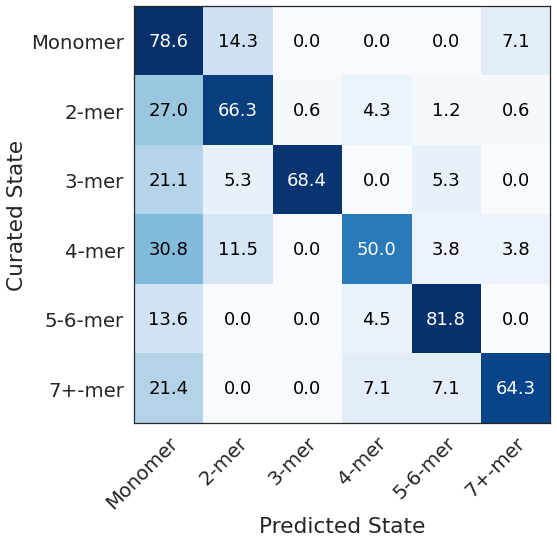

In [661]:
# make a confusion matrix of the predictions 
# Filter ambiguous rows (optional)
df = iptm_predictions[iptm_predictions['curated_state_bin'] != 'ambiguous'].copy()
sns.set(font_scale=1.8, style='white')

# Create normalized confusion matrix
cm = pd.crosstab(
    df['curated_state_bin'],
    df['prediction_state_bin'],
    normalize='index'  # Normalize so rows sum to 1
)

# Define custom order with Monomer first
desired_order = ['Monomer', '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']

# Reorder rows and columns to match desired order
available_rows = [label for label in desired_order if label in cm.index]
available_cols = [label for label in desired_order if label in cm.columns]

cm = cm.reindex(index=available_rows, columns=available_cols, fill_value=0)

# Convert to numpy array and get labels
cm_array = cm.values
row_labels = cm.index.tolist()
col_labels = cm.columns.tolist()

# Create the plot using matplotlib imshow with manual annotations
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_array, cmap='Blues', aspect='auto', vmax=0.7)  # Set vmax to 0.7

# Add colorbar
#cbar = plt.colorbar(im, shrink=0.8)
# Force the plot to be square
ax.set_aspect('equal')


# Set ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels)
ax.set_yticklabels(row_labels)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add annotations manually
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        score = cm_array[i, j]
        text_color = "black" if score < 0.5 else "white"  # Set color based on the score (adjust threshold if needed)
        ax.text(j, i, f'{score*100:.1f}', ha="center", va="center", color=text_color, fontsize=18)

ax.set_xlabel("Predicted State")
ax.set_ylabel("Curated State")
fig.tight_layout()
plt.savefig('../figures/phelgm_confusionmatrix.png',  dpi=300, bbox_inches='tight')
plt.show()
 

## here manually interrogate the incorrect predictions 

In [592]:
incorrect_predictions = df[df['correct_label'] == 'Incorrect']

In [624]:
mer = incorrect_predictions[incorrect_predictions['prediction_state_bin'] == '2-mer']

In [642]:
mer[mer['curated_state_bin'] == 'phrog_45']

,phrog,max_iptm,max_iptm_subunits,curated_state_bin,prediction_state_bin,is_correct,correct_label


In [ ]:
# ignore the nones or ambiguous ones 

<Axes: xlabel='subunits', ylabel='iptm'>

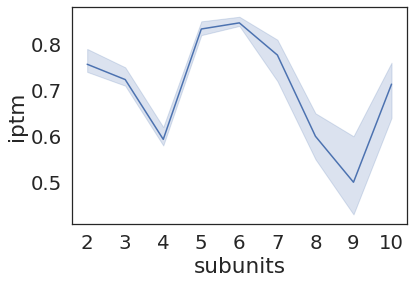

In [643]:
sns.lineplot(data=metrics_df[metrics_df['phrog'] == 'phrog_45'], x='subunits', y='iptm')

# for a case like this maybe can do a better job of separating 

In [615]:
metrics_df[metrics_df['phrog'] == 'phrog_7244']

,iptm,ptm,mean_plddt,mean_pdockq2,mean_plddt_lst,replicate,subunits,state_bin,phrog
0,0.28,0.46,82.810688,0.007348,0.000000,rep_1,2,4-mer,phrog_7244
0,0.22,0.43,80.370019,0.007348,0.000000,rep_2,2,4-mer,phrog_7244
0,0.19,0.43,81.400836,0.007348,0.000000,rep_3,2,4-mer,phrog_7244
0,0.61,0.64,83.712181,0.503372,0.891239,rep_1,3,4-mer,phrog_7244
0,0.61,0.64,82.034895,0.587987,0.921178,rep_2,3,4-mer,phrog_7244
0,0.59,0.63,81.555477,0.460517,0.894679,rep_3,3,4-mer,phrog_7244
0,0.66,0.69,83.562463,0.125049,0.710660,rep_1,4,4-mer,phrog_7244
0,0.65,0.67,82.496171,0.267617,0.804458,rep_2,4,4-mer,phrog_7244
0,0.64,0.66,82.981524,0.120165,0.702237,rep_3,4,4-mer,phrog_7244
0,0.71,0.72,84.390929,0.226851,0.786517,rep_1,5,4-mer,phrog_7244


<Axes: xlabel='subunits', ylabel='iptm'>

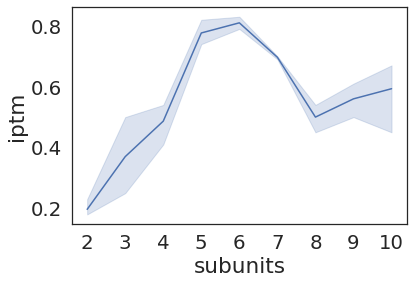

In [603]:
sns.lineplot(data=metrics_df[metrics_df['phrog'] == 'phrog_365'], x='subunits', y='iptm')

<Axes: xlabel='subunits', ylabel='iptm'>

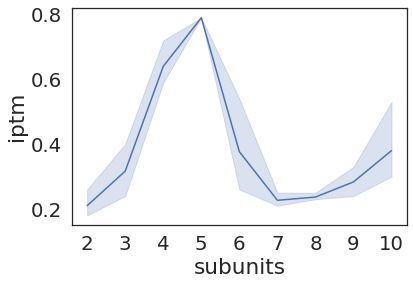

In [607]:
sns.lineplot(data=metrics_df[metrics_df['phrog'] == 'phrog_14789'], x='subunits', y='iptm')



<Axes: xlabel='subunits', ylabel='iptm'>

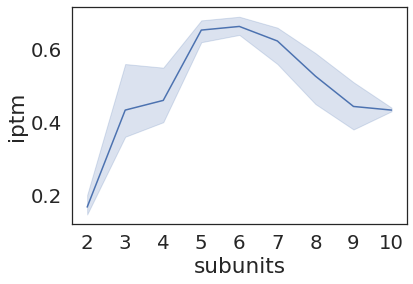

In [604]:
sns.lineplot(data=metrics_df[metrics_df['phrog'] == 'phrog_26606'], x='subunits', y='iptm')

In [294]:
#metrics_df[metrics_df['phrog'] == p]['state_bin'].iloc[0]

In [295]:
# loop through the phrogs 

#for p in  phrogs_pass_alphafold_seen: 

#    bin = metrics_df[metrics_df['phrog'] == p]['state_bin'].iloc[0] 
#    if bin == '7+-mer': 
#        print(p)
#        sns.lineplot(data=metrics_df[metrics_df['phrog'] == p], x='subunits', y='iptm')
#        plt.ylim((0,1))
#        plt.show()

<Axes: xlabel='subunits', ylabel='iptm'>

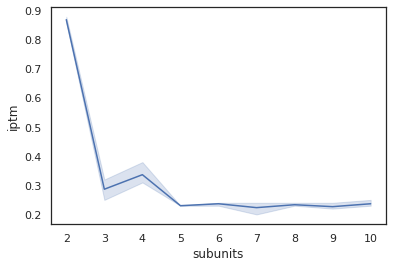

In [529]:
sns.lineplot(data=metrics_df[metrics_df['phrog'] == p], x='subunits', y='iptm')

In [361]:
# Step 1: Drop missing state_bin
filtered = metrics_df.dropna(subset=['state_bin'])

# Step 2: Aggregate per (phrog, subunits) — take max of each metric
agg_df = (
    filtered
    .groupby(['phrog', 'subunits', 'state_bin'])
    .agg({
        'iptm': 'max',
        'ptm': 'max',
        'mean_plddt': 'max',
        'mean_pdockq2': 'max',
        'mean_plddt_lst': 'max'
    })
    .reset_index()
)

# Step 3: For each phrog, pick the subunit with the highest iptm
best_by_iptm = (
    agg_df
    .sort_values(by='iptm', ascending=False)
    .drop_duplicates(subset='phrog')
    .loc[:, ['phrog', 'subunits', 'state_bin', 'iptm']]
    .rename(columns={'state_bin': 'predicted_state_bin'})
)

# Display result
print(best_by_iptm.head())


            phrog subunits predicted_state_bin  iptm
3533   phrog_7573        6             5-6-mer  0.96
1744  phrog_26048        8              7+-mer  0.96
1144  phrog_18935        2               2-mer  0.96
2395  phrog_33145        2               2-mer  0.96
3605   phrog_7995        6             5-6-mer  0.96


In [365]:
   (agg_df
    .sort_values(by='iptm', ascending=False)
    .drop_duplicates(subset='phrog')
    .loc[:, ['phrog', 'subunits', 'state_bin', 'iptm']])

,phrog,subunits,state_bin,iptm
3533,phrog_7573,6,5-6-mer,0.96
1744,phrog_26048,8,7+-mer,0.96
1144,phrog_18935,2,2-mer,0.96
2395,phrog_33145,2,2-mer,0.96
3605,phrog_7995,6,5-6-mer,0.96
...,...,...,...,...
855,phrog_16693,1,Monomer,0.16
1866,phrog_26873,4,Monomer,0.16
666,phrog_14794,1,Monomer,0.16
1575,phrog_242,1,2-mer,0.16


In [352]:
# for increments of 0.5 see which prediction is correct 
best_by_iptm[best_by_iptm['predicted_state_bin'] != 'Monomer']

vals = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] 
number_predictions = [] 
portion_correct = [] 

for v in vals: 
    
    p = best_by_iptm[best_by_iptm['iptm'] >= v] 
    number_predictions.append(len(p))
    portion_correct.append(len(p[p['predicted_state_bin'] == p['true_state_bin']])/len(p))

In [341]:
number_predictions

[370, 355, 341, 317, 297, 283, 264, 253, 230, 202, 178, 138, 96, 13]

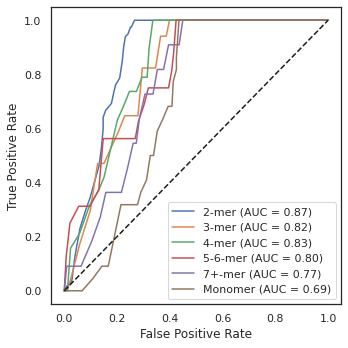

In [311]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Step 1: Aggregate metrics
filtered = metrics_df.dropna(subset=['state_bin'])
agg_df = (
    filtered
    .groupby(['phrog', 'subunits', 'state_bin'])
    .agg({
        'iptm': 'max',
        'ptm': 'max',
        'mean_plddt': 'max',
        'mean_pdockq2': 'max',
        'mean_plddt_lst': 'max'
    })
    .reset_index()
)

# Step 2: Select best-scoring configuration per PHROG
best_per_phrog = (
    agg_df
    .sort_values('iptm', ascending=False)
    .drop_duplicates('phrog')
    .copy()
)

# Step 3: Apply IPTM cutoff to define predicted state_bin
iptm_cutoff = 0.75
best_per_phrog['predicted_state_bin'] = best_per_phrog.apply(
    lambda row: row['state_bin'] if row['iptm'] >= iptm_cutoff else 'Monomer_or_Undefined',
    axis=1
)

# Step 4: Prepare data for ROC/PR curves
valid_preds = best_per_phrog.dropna(subset=['state_bin', 'iptm'])
y_true = valid_preds['predicted_state_bin'].values
y_score = valid_preds['iptm'].values
classes = sorted(set(y_true) - {'Monomer_or_Undefined'})  # exclude fallback class
y_true_bin = label_binarize(y_true, classes=classes)

# Step 5: Compute ROC and PR curves
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
avg_precision = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_true_bin[:, i], y_score)
    roc_auc[cls] = auc(fpr[cls], tpr[cls])
    precision[cls], recall[cls], _ = precision_recall_curve(y_true_bin[:, i], y_score)
    avg_precision[cls] = average_precision_score(y_true_bin[:, i], y_score)

# Step 6: Plot ROC curves
plt.figure(figsize=(5, 5))
for cls in classes:
    plt.plot(fpr[cls], tpr[cls], label=f"{cls} (AUC = {roc_auc[cls]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(facecolor='white')
plt.tight_layout()
plt.show()


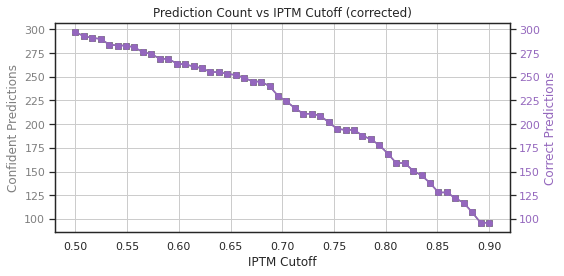

In [316]:
confident_counts = []
correct_counts = []

for cutoff in cutoff_values:
    # Get best iptm-scoring configuration for each PHROG
    best_per_phrog = (
        agg_df
        .sort_values('iptm', ascending=False)
        .drop_duplicates('phrog')
        .copy()
    )

    # Use the predicted state from that configuration, if IPTM passes cutoff
    best_per_phrog['predicted_state_bin'] = best_per_phrog['state_bin']
    best_per_phrog.loc[best_per_phrog['iptm'] < cutoff, 'predicted_state_bin'] = 'Monomer_or_Undefined'

    # Filter out fallback predictions
    confident = best_per_phrog[best_per_phrog['predicted_state_bin'] != 'Monomer_or_Undefined']
    confident_counts.append(len(confident))

    # Now compare predicted vs true label
    true_labels = [state_bins_dict.get(phrogs_pass_alphafold_seen_state.get(phrog)) for phrog in confident['phrog']]
    predicted_labels = confident['predicted_state_bin'].values

    correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
    correct_counts.append(correct)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(8, 4))

color1 = 'tab:gray'
color2 = 'tab:purple'

ax1.set_xlabel("IPTM Cutoff")
ax1.set_ylabel("Confident Predictions", color=color1)
ax1.plot(cutoff_values, confident_counts, color=color1, marker='s', label='Confident')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Correct Predictions", color=color2)
ax2.plot(cutoff_values, correct_counts, color=color2, marker='o', label='Correct')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Prediction Count vs IPTM Cutoff (corrected)")
fig.tight_layout()
plt.show()


In [120]:
import pickle
import pandas as pd
import re
from collections import Counter

# Map oligomeric states to their correct number of subunits
true_states = {
    'Monomer': 1,
    'Homo 2-mer': 2,
    'Homo 3-mer': 3,
    'Homo 4-mer': 4,
    'Homo 5-mer': 5,
    'Homo 6-mer': 6,
    'Homo 7-mer': 7,
    'Homo 8-mer': 8,
    'Homo 9-mer': 9,
    'Homo 10-mer': 10
}

# Exclude monomers from the set of states to evaluate
states_to_include = {k: v for k, v in true_states.items() if v != 1}

# Combine all seen PHROGs into one list (excluding monomers)
seen_phrogs_by_state = {
    k: [i for i in all_phrogs_pickle_complete_seen if phrogs_pass_alphafold_seen_state.get(i) == k]
    for k in states_to_include
}

results = []

# Evaluate each PHROG (excluding monomers)
for state, phrog_list in seen_phrogs_by_state.items():
    true_subunit = states_to_include[state]
    for m in phrog_list:
        try:
            loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
            stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient='index')).stack().reset_index(name="metrics")
            expanded = pd.concat(
                [stacked, pd.json_normalize(stacked["metrics"])], axis=1
            ).drop(columns="metrics")
            expanded['num_subunits'] = expanded['level_0'].apply(lambda x: int(x.split('_')[0]))
            
            # Get the subunit count with the highest ipTM score
            best_pred = expanded.loc[expanded['iptm'].idxmax(), 'num_subunits']
            correct = (best_pred == true_subunit)
            results.append({'phrog': m, 'true': true_subunit, 'predicted': best_pred, 'correct': correct})
        except Exception as e:
            print(f"Error processing {m}: {e}")

# Convert results to DataFrame and print summary
results_df = pd.DataFrame(results)
summary = results_df['correct'].value_counts()
print("Accuracy (excluding monomers):", summary.get(True, 0) / len(results_df))
print("Summary:")
print(summary)


Accuracy (excluding monomers): 0.72
Summary:
True     198
False     77
Name: correct, dtype: int64


In [113]:
## Needs a first step here to determine if an ipTM score is provided at all 

## Show difference in the ipTM score by state 

In [114]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define grouping function
def remap_class(n):
    if n in [5, 6]:
        return "5-6"
    elif n >= 7:
        return "7+"
    else:
        return str(n)

# Map oligomeric states (excluding monomers)
true_states = {
    'Homo 2-mer': 2,
    'Homo 3-mer': 3,
    'Homo 4-mer': 4,
    'Homo 5-mer': 5,
    'Homo 6-mer': 6,
    'Homo 7-mer': 7,
    'Homo 8-mer': 8,
    'Homo 9-mer': 9,
    'Homo 10-mer': 10
}

# Gather PHROGs by state
seen_phrogs_by_state = {
    state: [i for i in all_phrogs_pickle_complete_seen if phrogs_pass_alphafold_seen_state.get(i) == state]
    for state in true_states
}

# Collect ipTM scores with associated true class
iptm_rows = []

for state, phrog_list in seen_phrogs_by_state.items():
    true_subunit = true_states[state]
    true_group = remap_class(true_subunit)

    for m in phrog_list:
        try:
            loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
            stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient='index')).stack().reset_index(name="metrics")
            expanded = pd.concat(
                [stacked, pd.json_normalize(stacked["metrics"])], axis=1
            ).drop(columns="metrics")
            expanded['num_subunits'] = expanded['level_0'].apply(lambda x: int(x.split('_')[0]))

            # Max ipTM from all models for this PHROG
            max_iptm = expanded['iptm'].max()
            iptm_rows.append({"true_group": true_group, "iptm": max_iptm})
        except Exception as e:
            print(f"Error processing {m}: {e}")

# Create DataFrame
iptm_df = pd.DataFrame(iptm_rows)
iptm_df = iptm_df.dropna(subset=["iptm"])
iptm_df["iptm"] = pd.to_numeric(iptm_df["iptm"], errors="coerce")


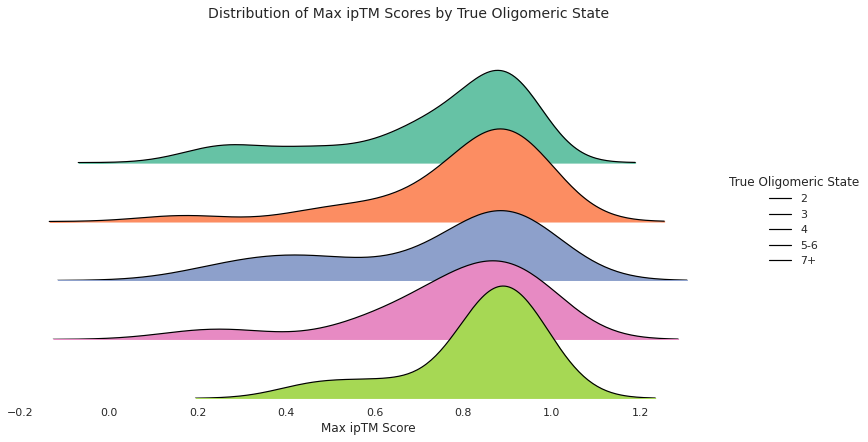

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert ipTM to numeric explicitly
iptm_df["iptm"] = pd.to_numeric(iptm_df["iptm"], errors="coerce")
iptm_df = iptm_df.dropna(subset=["iptm"])  # drop any rows with non-numeric iptm

# Convert "true_group" into an ordered categorical variable for consistent plotting
group_order = ["2", "3", "4", "5-6", "7+"]
iptm_df["true_group"] = pd.Categorical(iptm_df["true_group"], categories=group_order, ordered=True)

# Set aesthetic style
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
palette = sns.color_palette("Set2", n_colors=len(group_order))

# Create the ridgeline-style FacetGrid
g = sns.FacetGrid(
    iptm_df,
    row="true_group",
    hue="true_group",
    palette=palette,
    aspect=9,
    height=1.2
)
g.map_dataframe(sns.kdeplot, x="iptm", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="iptm", color='black', linewidth=1.2)

# Remove extra spacing and clutter
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Max ipTM Score")
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-0.5)

# Add the legend
g.add_legend(title="True Oligomeric State", label_order=group_order, adjust_subtitles=True)


# Optional: figure title
plt.suptitle("Distribution of Max ipTM Scores by True Oligomeric State", y=1.02, fontsize=14)

plt.show()


remake this plot for when proteins are not in their corrrect states - could put the two side by side 

## ROC Curve using the max ipTM score

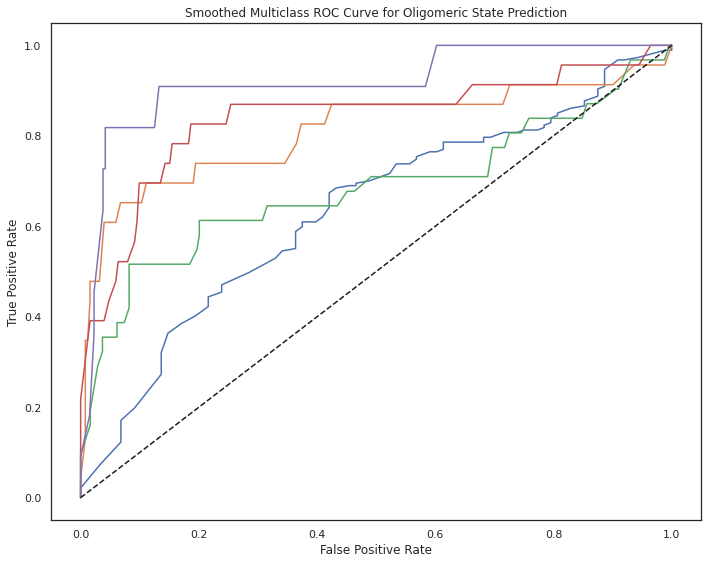

In [116]:
import pickle
import pandas as pd
import re
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Grouping function
def remap_class(n):
    if n in [5, 6]:
        return "5-6"
    elif n >= 7:
        return "7+"
    else:
        return str(n)

# Define all grouped class labels
grouped_labels = ["2", "3", "4", "5-6", "7+"]

# Map true oligomeric states
true_states = {
    'Monomer': 1,
    'Homo 2-mer': 2,
    'Homo 3-mer': 3,
    'Homo 4-mer': 4,
    'Homo 5-mer': 5,
    'Homo 6-mer': 6,
    'Homo 7-mer': 7,
    'Homo 8-mer': 8,
    'Homo 9-mer': 9,
    'Homo 10-mer': 10
}

# Exclude monomers
states_to_include = {k: v for k, v in true_states.items() if v != 1}

# Gather PHROGs by state
seen_phrogs_by_state = {
    k: [i for i in all_phrogs_pickle_complete_seen if phrogs_pass_alphafold_seen_state.get(i) == k]
    for k in states_to_include
}

# Store scores and true labels
all_scores = []
true_classes = []

# Process each PHROG
for state, phrog_list in seen_phrogs_by_state.items():
    true_subunit = states_to_include[state]
    true_class_grouped = remap_class(true_subunit)

    for m in phrog_list:
        try:
            loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
            stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient='index')).stack().reset_index(name="metrics")
            expanded = pd.concat(
                [stacked, pd.json_normalize(stacked["metrics"])], axis=1
            ).drop(columns="metrics")
            expanded['num_subunits'] = expanded['level_0'].apply(lambda x: int(x.split('_')[0]))

            # Group subunits into categories and retain max ipTM per group
            expanded['grouped'] = expanded['num_subunits'].apply(remap_class)
            grouped_scores = expanded.groupby('grouped')['iptm'].max().to_dict()

            # Fill missing groups with 0.0
            iptm_vector = [grouped_scores.get(g, 0.0) for g in grouped_labels]
            all_scores.append(iptm_vector)
            true_classes.append(true_class_grouped)

        except Exception as e:
            print(f"Error processing {m}: {e}")

# Binarize for ROC curve
y_true = label_binarize(true_classes, classes=grouped_labels)
y_score = pd.DataFrame(all_scores, columns=grouped_labels).values

# Plot ROC
plt.figure(figsize=(10, 8))
for i, group in enumerate(grouped_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{group}-mer (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Smoothed Multiclass ROC Curve for Oligomeric State Prediction")
plt.tight_layout()
plt.show()


## Predicting the oligomeric state 
This script evaluates the performance of oligomeric state prediction by generating multiclass ROC curves based on AlphaFold ipTM scores. To address class imbalance and reduce false positives—particularly for 2-mers—it applies a threshold-based suppression rule: a 2-mer prediction is only retained if its ipTM score exceeds all other class scores by a configurable margin (default: 0.05). Oligomeric states are grouped into five classes (2, 3, 4, 5-6, and 7+) to improve robustness and interpretability. The script loads predictions from pickle files, extracts the maximum ipTM per class group, and uses these as confidence scores for ROC analysis.

In [117]:
expanded.columns

Index(['level_0', 'level_1', 'iptm', 'ptm', 'max_pae', 'mean_plddt',
       'median_plddt', 'pdockq2', 'avgif_pae', 'plddt_lst', 'n_contacts_1A',
       'n_contacts_2A', 'n_contacts_3A', 'n_contacts_4A', 'n_contacts_5A',
       'n_contacts_6A', 'n_contacts_7A', 'n_contacts_8A', 'n_contacts_9A',
       'num_subunits', 'grouped'],
      dtype='object')

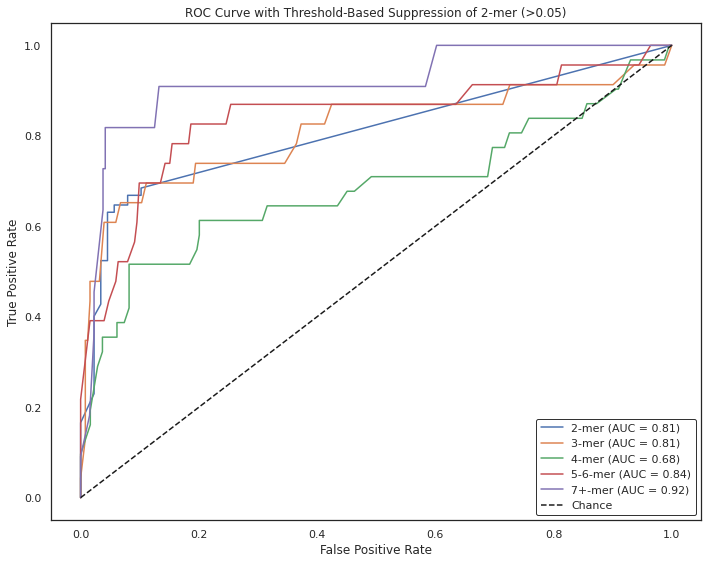

In [118]:
import pickle
import pandas as pd
import re
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
threshold_margin = 0.05  # Only predict 2-mer if it's this much higher than all others
grouped_labels = ["2", "3", "4", "5-6", "7+"]

def remap_class(n):
    if n in [5, 6]:
        return "5-6"
    elif n >= 7:
        return "7+"
    else:
        return str(n)

# Map true oligomeric states
true_states = {
    'Monomer': 1,
    'Homo 2-mer': 2,
    'Homo 3-mer': 3,
    'Homo 4-mer': 4,
    'Homo 5-mer': 5,
    'Homo 6-mer': 6,
    'Homo 7-mer': 7,
    'Homo 8-mer': 8,
    'Homo 9-mer': 9,
    'Homo 10-mer': 10
}
states_to_include = {k: v for k, v in true_states.items() if v != 1}

seen_phrogs_by_state = {
    k: [i for i in all_phrogs_pickle_complete_seen if phrogs_pass_alphafold_seen_state.get(i) == k]
    for k in states_to_include
}

all_scores = []
true_classes = []

for state, phrog_list in seen_phrogs_by_state.items():
    true_subunit = states_to_include[state]
    true_class_grouped = remap_class(true_subunit)

    for m in phrog_list:
        try:
            loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
            stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient='index')).stack().reset_index(name="metrics")
            expanded = pd.concat(
                [stacked, pd.json_normalize(stacked["metrics"])], axis=1
            ).drop(columns="metrics")
            expanded['num_subunits'] = expanded['level_0'].apply(lambda x: int(x.split('_')[0]))
            expanded['grouped'] = expanded['num_subunits'].apply(remap_class)

            grouped_scores = expanded.groupby('grouped')['iptm'].max().to_dict()
            iptm_2 = grouped_scores.get("2", 0)
            other_scores = {k: v for k, v in grouped_scores.items() if k != "2"}
            max_other_score = max(other_scores.values(), default=0)

            # Apply threshold suppression
            if iptm_2 > max_other_score + threshold_margin:
                final_scores = grouped_scores
            else:
                grouped_scores["2"] = 0.0  # Suppress
                final_scores = grouped_scores

            # Final score vector
            iptm_vector = [final_scores.get(g, 0.0) for g in grouped_labels]
            all_scores.append(iptm_vector)
            true_classes.append(true_class_grouped)

        except Exception as e:
            print(f"Error processing {m}: {e}")

# Binarize for ROC curve
y_true = label_binarize(true_classes, classes=grouped_labels)
y_score = pd.DataFrame(all_scores, columns=grouped_labels).values

# Plot ROC
plt.figure(figsize=(10, 8))
for i, group in enumerate(grouped_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{group}-mer (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve with Threshold-Based Suppression of 2-mer (>{threshold_margin})")

# Fix legend background
leg = plt.legend(loc="lower right")
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.show()




In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Example: Assume you already have a DataFrame `df` with the following columns:
# 'max_pae', 'mean_plddt', 'median_plddt', 'pdockq2', 'avgif_pae', 'iptm', 'label'
# where 'label' is 0 for monomer and 1 for dimer

# Define feature matrix and labels
features = ['max_pae', 'mean_plddt', 'median_plddt', 'pdockq2', 'avgif_pae', 'iptm']
X = df[features].values
y = df['label'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_scaled, y)

# Predict probabilities
y_score = clf.predict_proba(X_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_score)
roc_auc = roc_auc_score(y, y_score)

# Plot ROC curve
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"LogReg AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Oligomeric State Prediction')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

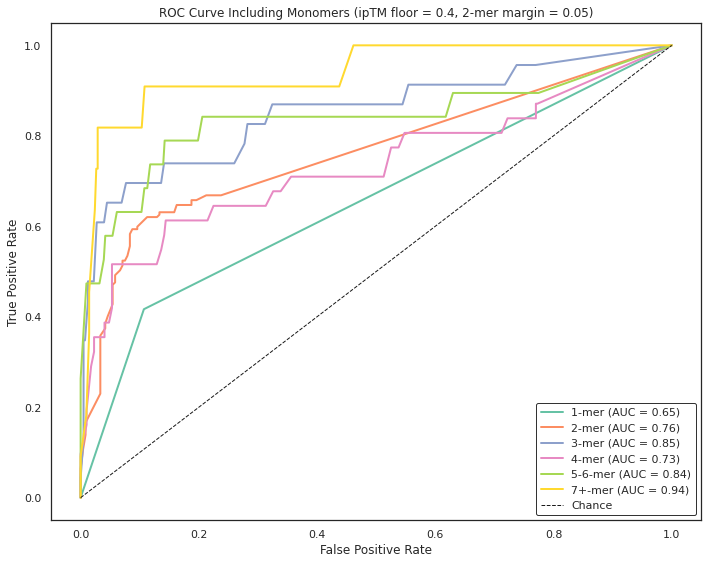

In [24]:
import pickle
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- CONFIGURATION ---
threshold_margin = 0.05   # ipTM difference required to call 2-mer confidently
iptm_floor = 0.4          # If all ipTM scores are below this, call it a monomer
grouped_labels = ["1", "2", "3", "4", "5-6", "7+"]

def remap_class(n):
    if n in [5, 6]:
        return "5-6"
    elif n >= 7:
        return "7+"
    else:
        return str(n)

# True oligomeric states
true_states = {
    'Monomer': 1,
    'Homo 2-mer': 2,
    'Homo 3-mer': 3,
    'Homo 4-mer': 4,
    'Homo 5-mer': 5,
    'Homo 6-mer': 6,
    'Homo 7-mer': 7,
    'Homo 8-mer': 8,
    'Homo 9-mer': 9,
    'Homo 10-mer': 10
}

# Include all states including monomers
states_to_include = true_states

# Group PHROGs by state
seen_phrogs_by_state = {
    k: [i for i in all_phrogs_pickle_complete_seen if phrogs_pass_alphafold_seen_state.get(i) == k]
    for k in states_to_include
}

# Collect prediction scores and true labels
all_scores = []
true_classes = []

for state, phrog_list in seen_phrogs_by_state.items():
    true_subunit = states_to_include[state]
    true_class_grouped = remap_class(true_subunit)

    for m in phrog_list:
        try:
            loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
            stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient='index')).stack().reset_index(name="metrics")
            expanded = pd.concat(
                [stacked, pd.json_normalize(stacked["metrics"])], axis=1
            ).drop(columns="metrics")
            expanded['num_subunits'] = expanded['level_0'].apply(lambda x: int(x.split('_')[0]))
            expanded['grouped'] = expanded['num_subunits'].apply(remap_class)

            # Get max ipTM score for each group
            grouped_scores = expanded.groupby('grouped')['iptm'].max().to_dict()
            iptm_2 = grouped_scores.get("2", 0.0)
            other_scores = {k: v for k, v in grouped_scores.items() if k != "2"}
            max_other_score = max(other_scores.values(), default=0)

            # --- Monomer-like case ---
            if all(v < iptm_floor for v in grouped_scores.values()):
                final_scores = {g: 0.0 for g in grouped_labels}
                final_scores["1"] = 1.0  # Predict monomer confidently

            # --- Confident 2-mer ---
            elif iptm_2 > max_other_score + threshold_margin:
                final_scores = grouped_scores

            # --- Suppress 2-mer if not dominant ---
            else:
                grouped_scores["2"] = 0.0
                final_scores = grouped_scores

            # Ensure all labels are represented
            for g in grouped_labels:
                final_scores.setdefault(g, 0.0)

            iptm_vector = [final_scores[g] for g in grouped_labels]
            all_scores.append(iptm_vector)
            true_classes.append(true_class_grouped)

        except Exception as e:
            print(f"Error processing {m}: {e}")

# --- ROC Curve ---
# Binarize true class labels
y_true = label_binarize(true_classes, classes=grouped_labels)
y_score = pd.DataFrame(all_scores, columns=grouped_labels).values

# Plot
plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set2", len(grouped_labels))

for i, group in enumerate(grouped_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{group}-mer (AUC = {roc_auc:.2f})", lw=2, color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', label="Chance", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve Including Monomers (ipTM floor = {iptm_floor}, 2-mer margin = {threshold_margin})")

# Legend aesthetics
leg = plt.legend(loc="lower right", frameon=True)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assume `results` has already been created
results_df = pd.DataFrame(results)

# Exclude monomers (true subunit count = 1)
filtered_df = results_df[results_df['true'] != 1]

# Get all states still present
all_states = sorted(set(filtered_df['true']).union(set(filtered_df['predicted'])))

# Compute confusion matrix
cm = confusion_matrix(filtered_df['true'], filtered_df['predicted'], labels=all_states)
cm_df = pd.DataFrame(cm, index=[f"True {i}" for i in all_states], columns=[f"Pred {i}" for i in all_states])

cm_df

,Pred 2,Pred 3,Pred 4,Pred 5,Pred 6,Pred 7,Pred 8,Pred 9,Pred 10
True 2,146,4,13,1,7,1,6,1,8
True 3,2,16,1,1,1,0,1,1,0
True 4,11,1,14,1,1,0,1,1,1
True 5,0,0,1,5,0,0,1,0,0
True 6,1,1,0,2,8,0,0,0,0
True 7,0,0,0,0,0,1,0,0,0
True 8,1,0,1,0,1,0,3,0,0
True 9,0,0,0,0,0,0,0,3,0
True 10,0,0,0,1,0,0,0,0,0


In [ ]:
# for the ones here that don't finish - improve the prediction across them 

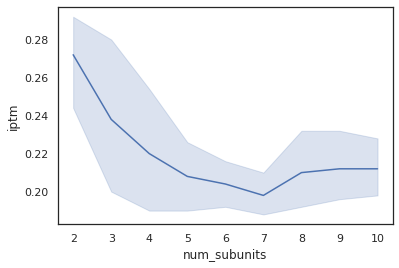

In [86]:
for m in ['phrog_16897']: 
    
    loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
    stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient = 'index')).stack().reset_index(name="metrics")
    expanded = pd.concat(
            [stacked, pd.json_normalize(stacked["metrics"])], axis=1
        ).drop(columns="metrics")
    expanded['num_subunits'] = [int(re.split('_',i)
                                        [0]) for i in expanded['level_0']] 

    sns.lineplot(data = expanded, x ='num_subunits', y = 'iptm', ) 
    plt.show()

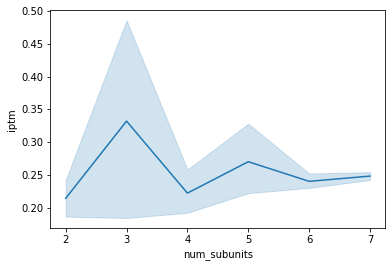

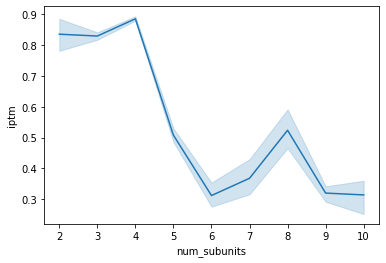

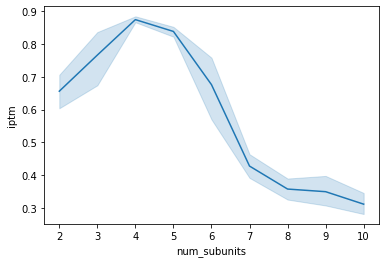

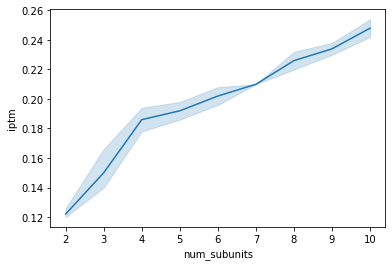

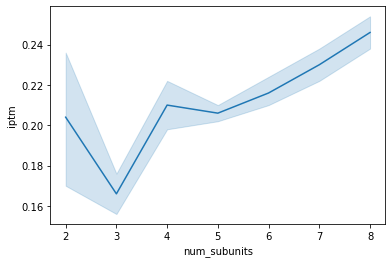

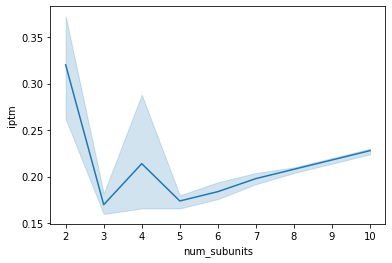

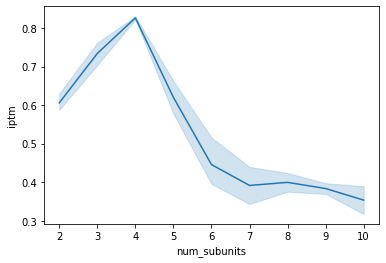

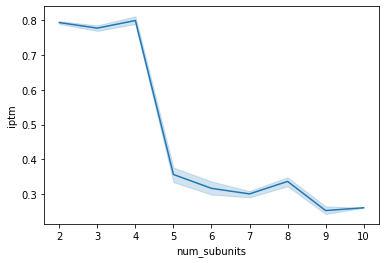

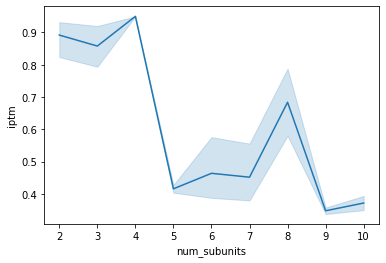

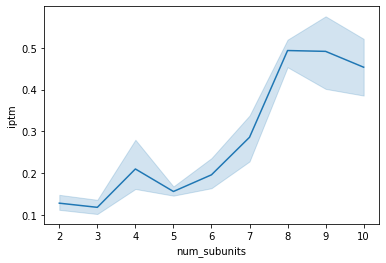

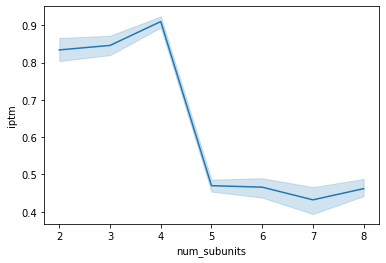

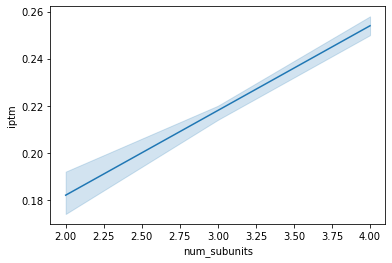

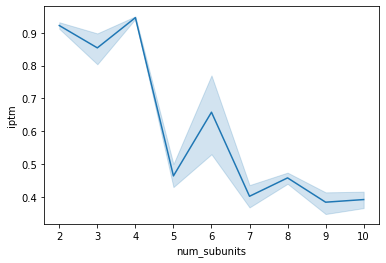

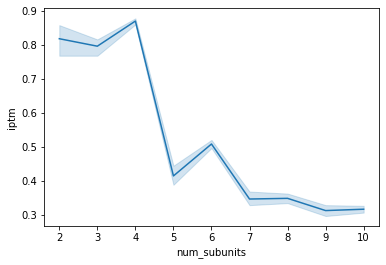

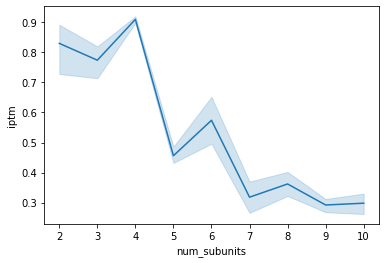

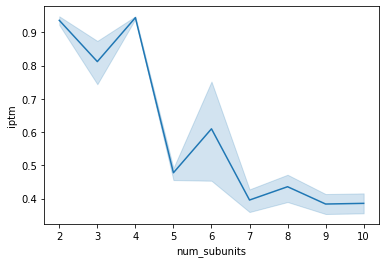

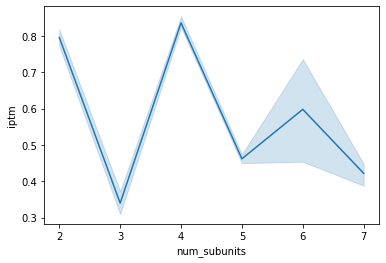

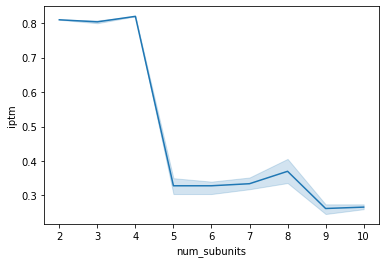

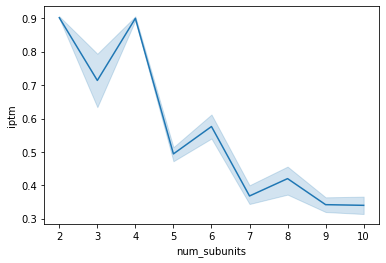

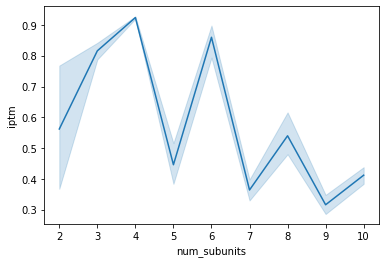

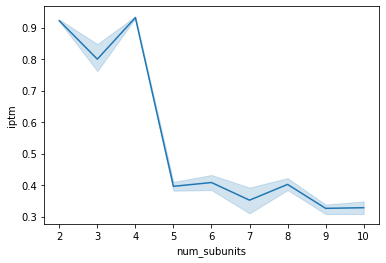

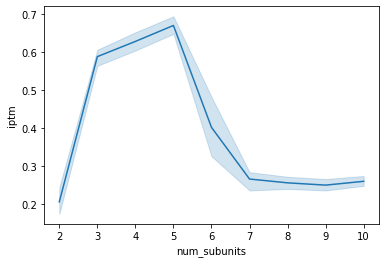

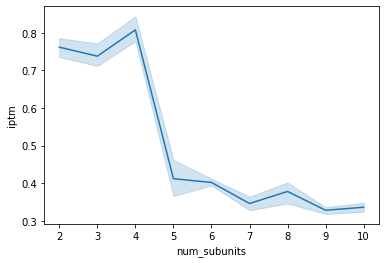

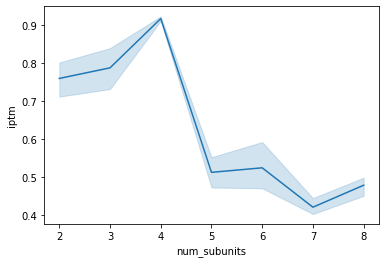

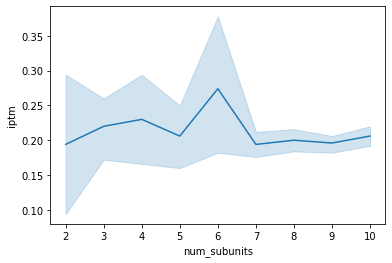

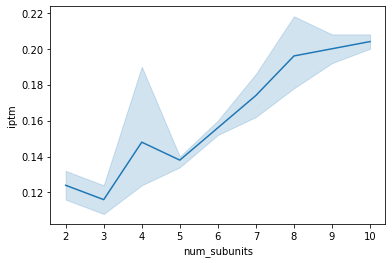

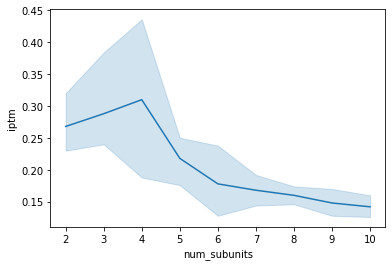

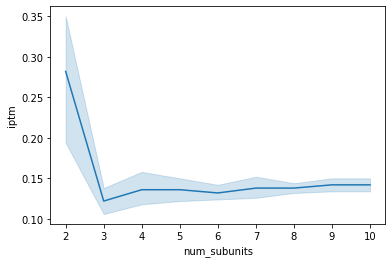

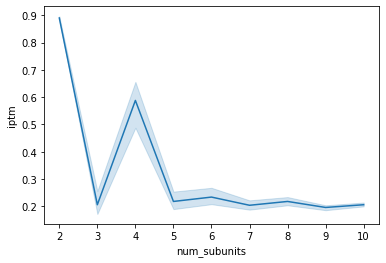

In [33]:
for m in seen_tetramers: 
    
    loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
    stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient = 'index')).stack().reset_index(name="metrics")
    expanded = pd.concat(
            [stacked, pd.json_normalize(stacked["metrics"])], axis=1
        ).drop(columns="metrics")
    expanded['num_subunits'] = [int(re.split('_',i)
                                        [0]) for i in expanded['level_0']] 

    sns.lineplot(data = expanded, x ='num_subunits', y = 'iptm', ) 
    plt.show()

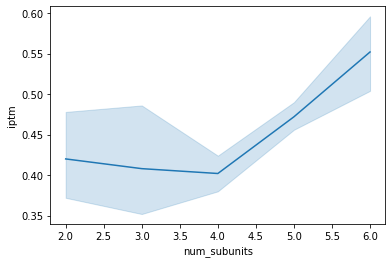

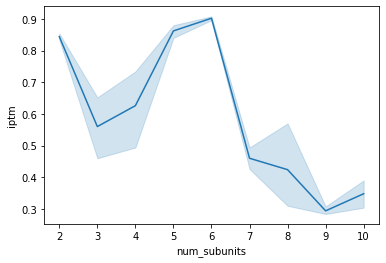

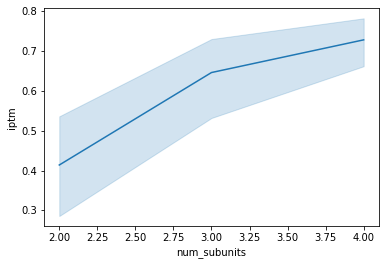

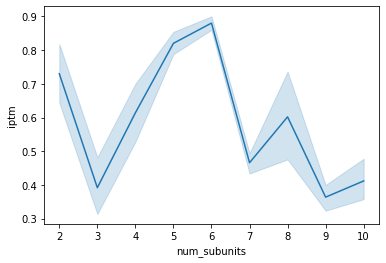

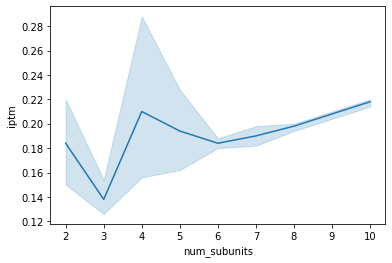

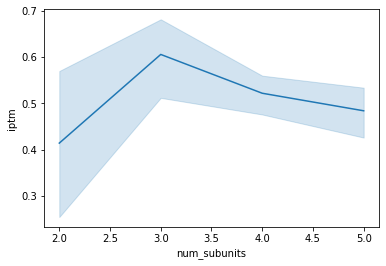

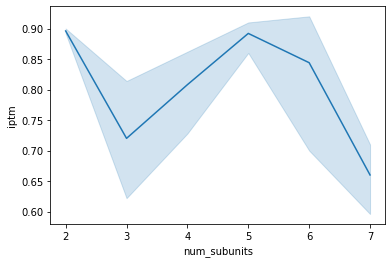

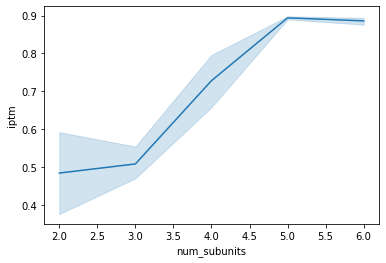

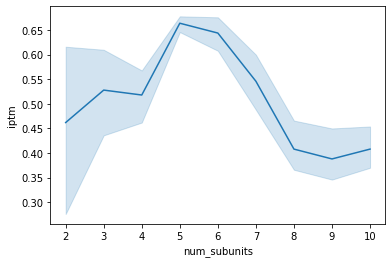

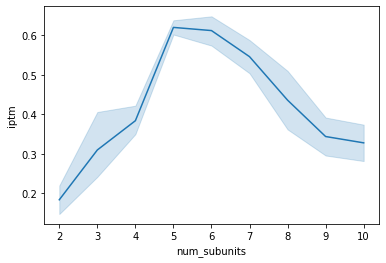

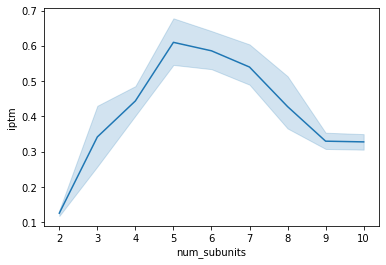

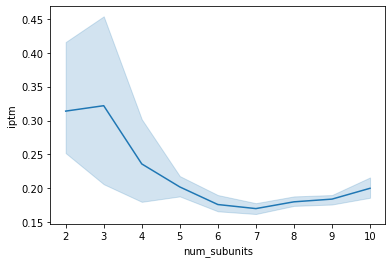

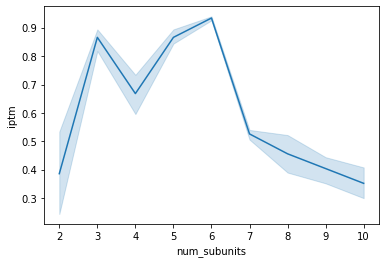

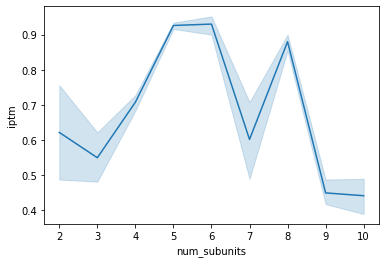

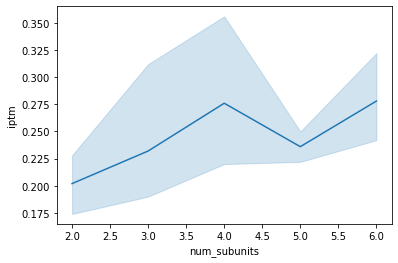

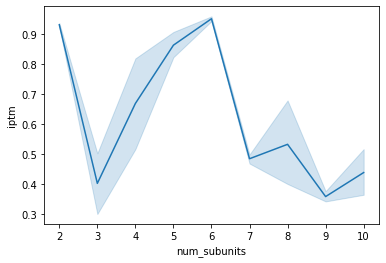

In [56]:
for m in seen_hexamers: 
    
    loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
    stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient = 'index')).stack().reset_index(name="metrics")
    expanded = pd.concat(
            [stacked, pd.json_normalize(stacked["metrics"])], axis=1
        ).drop(columns="metrics")
    expanded['num_subunits'] = [int(re.split('_',i)
                                        [0]) for i in expanded['level_0']] 

    sns.lineplot(data = expanded, x ='num_subunits', y = 'iptm', ) 
    plt.show()

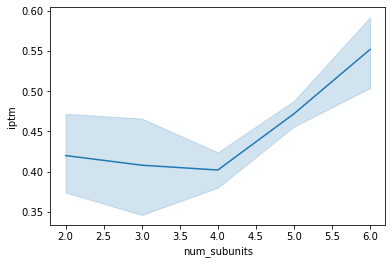

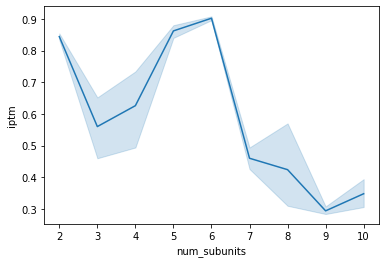

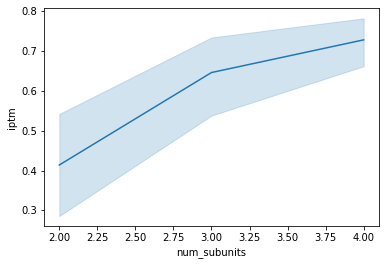

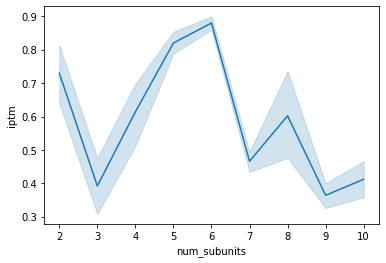

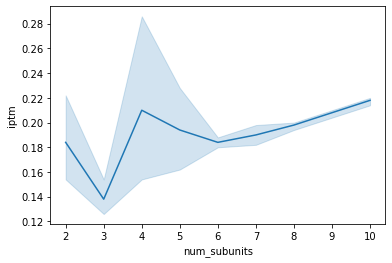

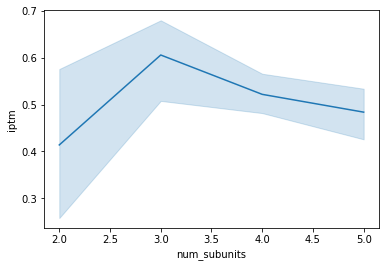

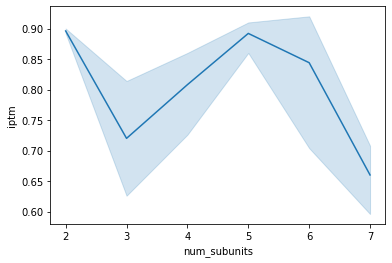

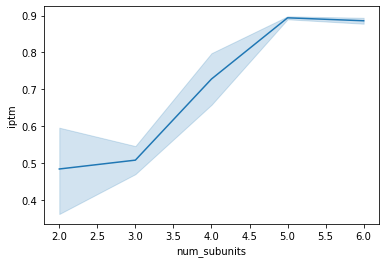

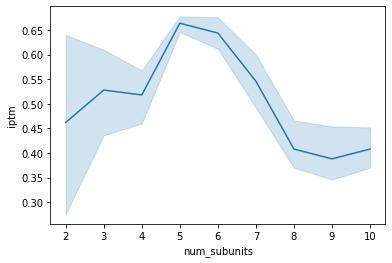

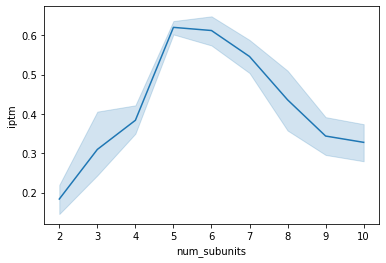

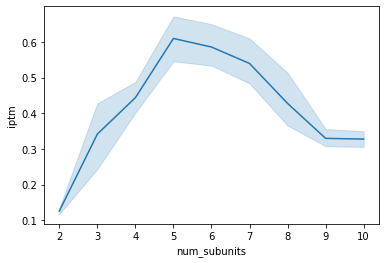

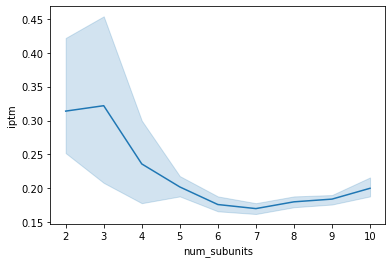

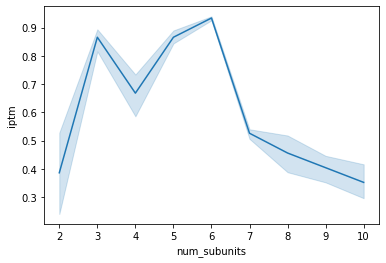

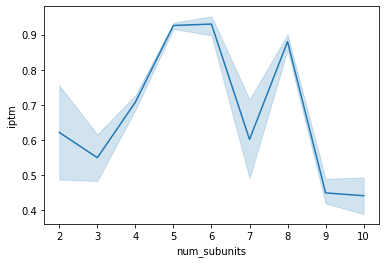

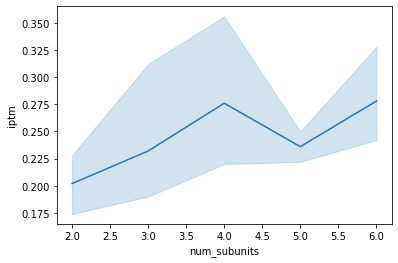

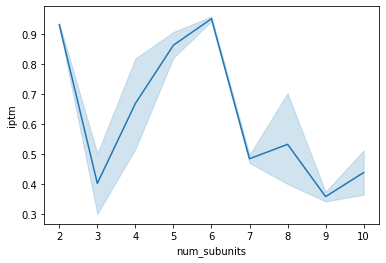

In [38]:
for m in seen_hexamers: 
    
    loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
    stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient = 'index')).stack().reset_index(name="metrics")
    expanded = pd.concat(
            [stacked, pd.json_normalize(stacked["metrics"])], axis=1
        ).drop(columns="metrics")
    expanded['num_subunits'] = [int(re.split('_',i)
                                        [0]) for i in expanded['level_0']] 

    sns.lineplot(data = expanded, x ='num_subunits', y = 'iptm', ) 
    plt.show()

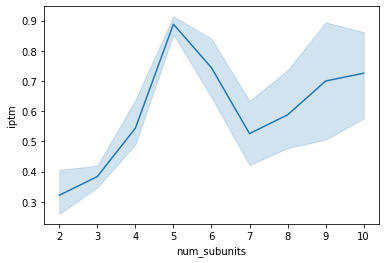

In [44]:
for m in seen_decamers: 
    
    loaded = pickle.load(open(pickle_paths.get(m), 'rb'))
    stacked = pd.DataFrame(pd.DataFrame.from_dict(loaded, orient = 'index')).stack().reset_index(name="metrics")
    expanded = pd.concat(
            [stacked, pd.json_normalize(stacked["metrics"])], axis=1
        ).drop(columns="metrics")
    expanded['num_subunits'] = [int(re.split('_',i)
                                        [0]) for i in expanded['level_0']] 

    sns.lineplot(data = expanded, x ='num_subunits', y = 'iptm', ) 
    plt.show()